# Определение возраста покупателей

### Описание проекта <br>
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы: <br>
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; <br>
- Контролировать добросовестность кассиров при продаже алкоголя. <br>

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Загрузка датасета

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
labels.shape

(7591, 2)

В датасете представлено 7591 значение

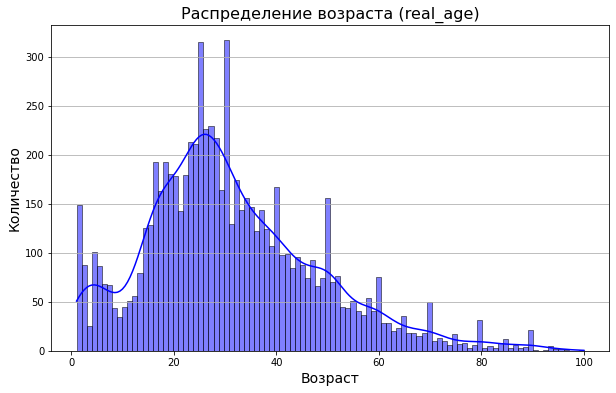

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=100, kde=True, color='blue')
plt.title('Распределение возраста (real_age)', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.grid(axis='y')
plt.show()

На распределении видно, что пик приходится на возраст от 18 до 35 лет. Датасет в основном содержит молодую аудиторию, где преобладают люди старше 18 лет

Это может повлиять на обучение модели. Модель будет лучше определять возраст молодых людей, так как для этой группы имеется больше данных. Для анализа покупательского поведения это может быть проблемой, однако для задачи определения возраста в контексте продажи алкоголя это не столь критично, поскольку цель заключается в определении, превышает ли возраст человека 18 лет или нет (задача классификации)

In [5]:
zero_age_images = labels[labels['real_age'] == 0]

zero_age_images

,file_name,real_age


Нулевых значений нет, данные верны

In [6]:
datagen = ImageDataGenerator(rescale=1. / 255)

data_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    seed=42
)

images, ages = next(data_generator)

Found 7591 validated image filenames.


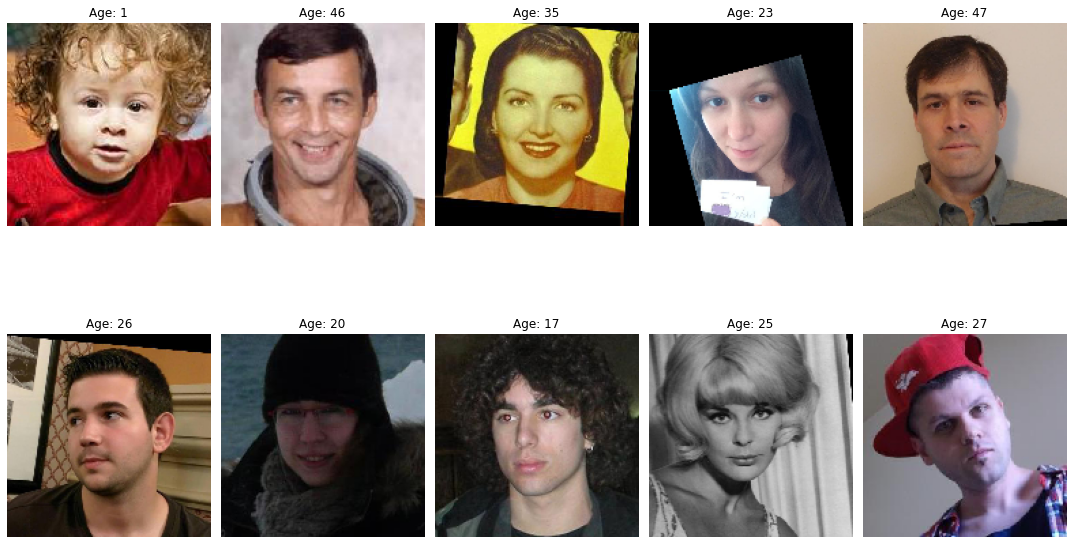

In [7]:
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Age: {int(ages[i])}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Изображения загружены и выглядят корректно

#### Промежуточный вывод <br>
- В датасете представлено 7591 фотографий с указанием возраста. Этого количества должно быть достаточно для обучения модели. <br>
- Больше всего в датасете представлены фотографии людей в возрасте от 18 до 35 лет. Это может повлиять на обучение модели, так как для молодых людей данных больше. <br>
- Некоторые фотографии черно-белые, на некоторых изображены посторонние предметы, некоторые фотографии повернуты или слишком отдалены. Для решения этой проблемы можно использовать аугментацию. <br>
- Есть всплески количества фото в юбилейные годы (30, 40, 50, 60)
- Рекомендованные аугментации: поворот изображения, отражение по горизонтали, изменение яркости и контраста, изменение размера изображения. <br>

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels_csv = f"{path}/labels.csv"
    images_dir = f"{path}/final_files"
    df = pd.read_csv(labels_csv)

    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        validation_split=0.25,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=images_dir,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42
    )
    return train_generator

def load_test(path):
    labels_csv = f"{path}/labels.csv"
    images_dir = f"{path}/final_files"
    df = pd.read_csv(labels_csv)

    test_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        validation_split=0.25
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=images_dir,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42
    )
    return test_generator

def create_model(input_shape=(150, 150, 3)):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = train_data.samples // train_data.batch_size
    if validation_steps is None:
        validation_steps = test_data.samples // test_data.batch_size

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )
    return model
```

### Training Logs

**Train for 177 steps, validate for 59 steps**

**Epoch 1/20**
177/177 - 134s - loss: 209.5075 - mae: 10.9398 - val_loss: 355.9813 - val_mae: 14.0675

**Epoch 2/20**
177/177 - 102s - loss: 144.1827 - mae: 9.1818 - val_loss: 331.5946 - val_mae: 13.5326

**Epoch 3/20**
177/177 - 102s - loss: 132.1853 - mae: 8.7641 - val_loss: 357.6328 - val_mae: 14.0848

**Epoch 4/20**
177/177 - 102s - loss: 116.2247 - mae: 8.1874 - val_loss: 228.4058 - val_mae: 11.3239

**Epoch 5/20**
177/177 - 102s - loss: 109.6721 - mae: 7.9669 - val_loss: 109.7943 - val_mae: 7.9436

**Epoch 6/20**
177/177 - 102s - loss: 102.9975 - mae: 7.6669 - val_loss: 120.2866 - val_mae: 8.8049

**Epoch 7/20**
177/177 - 102s - loss: 98.7125 - mae: 7.4556 - val_loss: 123.1721 - val_mae: 8.7574

**Epoch 8/20**
177/177 - 102s - loss: 95.7147 - mae: 7.4570 - val_loss: 92.2127 - val_mae: 7.2771

**Epoch 9/20**
177/177 - 102s - loss: 85.2164 - mae: 7.0261 - val_loss: 229.3213 - val_mae: 11.4816

**Epoch 10/20**
177/177 - 103s - loss: 84.5749 - mae: 6.9868 - val_loss: 99.7005 - val_mae: 7.4234

**Epoch 11/20**
177/177 - 102s - loss: 79.2394 - mae: 6.7707 - val_loss: 89.2472 - val_mae: 6.9526

**Epoch 12/20**
177/177 - 102s - loss: 80.4295 - mae: 6.7584 - val_loss: 132.7043 - val_mae: 9.1551

**Epoch 13/20**
177/177 - 102s - loss: 82.8852 - mae: 6.8938 - val_loss: 149.0168 - val_mae: 9.3371

**Epoch 14/20**
177/177 - 103s - loss: 73.2221 - mae: 6.4935 - val_loss: 104.2180 - val_mae: 8.1025

**Epoch 15/20**
177/177 - 102s - loss: 70.0796 - mae: 6.3489 - val_loss: 97.8773 - val_mae: 7.2774

**Epoch 16/20**
177/177 - 103s - loss: 70.3622 - mae: 6.3572 - val_loss: 209.3508 - val_mae: 11.1453

**Epoch 17/20**
177/177 - 103s - loss: 68.8911 - mae: 6.3119 - val_loss: 80.4329 - val_mae: 6.6370

**Epoch 18/20**
177/177 - 104s - loss: 67.8200 - mae: 6.3055 - val_loss: 91.0359 - val_mae: 7.3672

**Epoch 19/20**
177/177 - 102s - loss: 63.3952 - mae: 6.0300 - val_loss: 106.3025 - val_mae: 7.5230

**Epoch 20/20**
177/177 - 102s - loss: 66.9924 - mae: 6.2094 - val_loss: 107.8748 - val_mae: 7.7726

---

**Final Evaluation**
60/60 - 11s - loss: 107.6184 - mae: 7.7749

Целевая метрика MAE на валидационной выборке составила 7.77, что удовлетворяет условиям задачи

## Анализ обученной модели

### Вывод <br>
В ходе проекта были выполнены следующие шаги: <br>
1. Исследовательский анализ данных <br>
2. Обучение модели ResNet50 <br>
3. В backbone ResNet50 были загружены предобученные веса <br>
4. Голова модели состоит из слоя GlobalAveragePooling2D и Dense с активацией ReLU <br>
5. Размер батча составил 32, оптимизатор - Adam с шагом обучения 0.0001, количество эпох - 20 <br>
6. Достигнута целевая метрика MAE на валидационной выборке (7.77) <br>

В качестве модели была выбрана ResNet50 с 20 эпохами обучения <br>

Модель может быть использована для определения возраста покупателей в сетевом супермаркете «Хлеб-Соль» для контроля продажи алакоголя <br>